# **Dataset used** : MNIST

# **Denoising** : Autoencoder

# **Comparison metrics** : Comparision of classification of Dataset with noise and after denoising

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
def test_classification(x_train, y_train, x_test, y_test):
    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
    x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)
    # Making sure that the values are float so that we can get decimal points after division
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    # Normalizing the RGB codes by dividing it to the max RGB value.
    x_train /= 255
    x_test /= 255
    print('x_train shape:', x_train.shape)
    print('Number of images in x_train', x_train.shape[0])
    print('Number of images in x_test', x_test.shape[0])
    classifier = keras.models.Sequential()
    classifier.add(keras.layers.Conv2D(28, kernel_size=(3,3), input_shape=input_shape))
    classifier.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    classifier.add(keras.layers.Flatten()) # Flattening the 2D arrays for fully connected layers
    classifier.add(keras.layers.Dense(128, activation=tf.nn.relu))
    classifier.add(keras.layers.Dropout(0.2))
    classifier.add(keras.layers.Dense(10,activation=tf.nn.softmax))
    classifier.summary()
    classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    classifier.fit(x=x_train,y=y_train, epochs=10)
    return classifier.evaluate(x_test, y_test)

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print("Train images shape: {}".format(x_train.shape))
print("Test images shape: {}".format(x_test.shape))
print("Train labels shape: {}".format(y_train.shape))
print("Test labels shape: {}".format(y_test.shape))

Train images shape: (60000, 28, 28)
Test images shape: (10000, 28, 28)
Train labels shape: (60000,)
Test labels shape: (10000,)


In [ ]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train_expanded = np.expand_dims(x_train, axis=3)
x_test_expanded = np.expand_dims(x_test, axis=3)

print("Train images shape: {}".format(x_train_expanded.shape))
print("Test images shape: {}".format(x_test_expanded.shape))

Train images shape: (60000, 28, 28, 1)
Test images shape: (10000, 28, 28, 1)


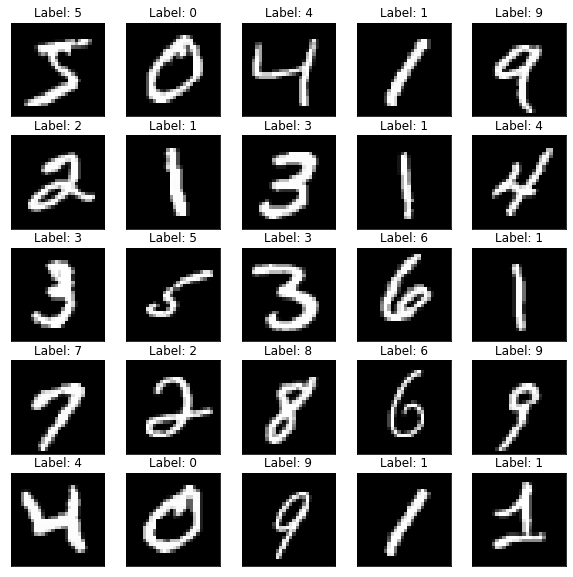

In [ ]:
#display sample images from the dataset
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title("Label: {}".format(y_train[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [ ]:
#add gausian noise to dataset
noise_factor = 0.1
x_train_noisy = x_train_expanded + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train_expanded.shape) 
x_test_noisy = x_test_expanded + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test_expanded.shape) 

#clip the data so that the pixel values are between 0 and 1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

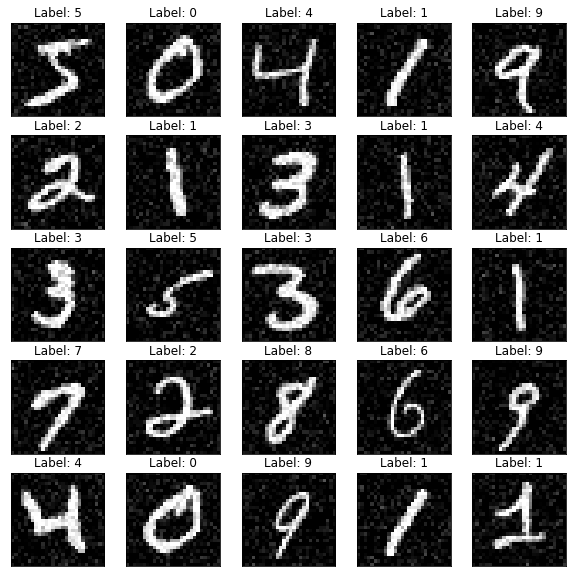

In [ ]:
#display the sample noisy images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(x_train_noisy[i, :, :, 0], cmap='gray')
    plt.title("Label: {}".format(y_train[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [ ]:
def encoder(input_img):
    """
    Encoder function.
    Arguments:
      input_img: Input image, Tensor of shape (28, 28, 1)
    
    Returns: Encoded image, Tensor of shape (7, 7, 8)
    """
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='encoder_conv1')(input_img)
    x = MaxPool2D((2, 2), padding='same', name='encoder_pool1')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same', name='encoder_conv2')(x)
    x = MaxPool2D((2, 2), padding='same', name='encoder_pool2')(x)
    encoded = Conv2D(8, (3, 3), activation='relu', padding='same', name='encoder_conv3')(x)
    return encoded


def decoder(encoded):
    """
    Decoder function.
    Arguments:
      encoded: Encoded image, Tensor of shape (7, 7, 8)
    
    Returns: Decoded images, Tensor of shape (28, 28, 1)
    """
    x = Conv2D(8, (3, 3), activation='relu', padding='same', name='decoder_conv1')(encoded)
    x = UpSampling2D((2, 2), name='decoder_upsample1')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same', name='decoder_conv2')(x)
    x = UpSampling2D((2, 2), name='decoder_upsample2')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='decoder_conv3')(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='decoder_conv4')(x)
    return decoded

In [ ]:
#create input tensor
input_img = Input(shape=(28, 28, 1))

#create autoencoder model
autoencoder = Model(input_img, decoder(encoder(input_img)))
#complile model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

#show model structure
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder_conv1 (Conv2D)       (None, 28, 28, 32)        320       
_________________________________________________________________
encoder_pool1 (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
encoder_conv2 (Conv2D)       (None, 14, 14, 16)        4624      
_________________________________________________________________
encoder_pool2 (MaxPooling2D) (None, 7, 7, 16)          0         
_________________________________________________________________
encoder_conv3 (Conv2D)       (None, 7, 7, 8)           1160      
_________________________________________________________________
decoder_conv1 (Conv2D)       (None, 7, 7, 8)           584 

In [ ]:
#define callback for earlystopping to stop training if the validation loss does not decrese for 10 epochs 
earlyStopping = EarlyStopping(monitor='val_loss', patience=10)

#define callback to save model weights if the validation loss improves
modelChkpt = ModelCheckpoint(filepath='best_weights.h5', monitor='val_loss', save_best_only=True) 

#train model
train_history = autoencoder.fit(x_train_noisy, x_train_expanded,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test_expanded),
                callbacks=[modelChkpt, earlyStopping]
)

Epoch 1/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1378 - val_loss: 0.0883
Epoch 2/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0847 - val_loss: 0.0806
Epoch 3/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0793 - val_loss: 0.0769
Epoch 4/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0768 - val_loss: 0.0749
Epoch 5/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0750 - val_loss: 0.0735
Epoch 6/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0737 - val_loss: 0.0725
Epoch 7/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0728 - val_loss: 0.0722
Epoch 8/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0721 - val_loss: 0.0715
Epoch 9/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0716 - val_loss: 0.0707
Epoch 10/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0711 - val_lo

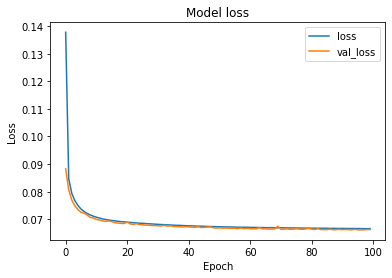

In [ ]:
#plot training and validation loss for model
plt.plot(train_history.history['loss'], label='loss')
plt.plot(train_history.history['val_loss'], label='val_loss')
plt.title("Model loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

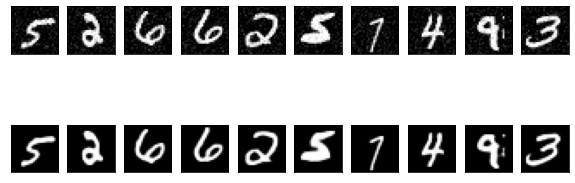

In [ ]:
#Display a random noisy test images and corresponding denoised images predicted by our model
n = 10 #number of random images to display
test_output = autoencoder.predict(x_test_noisy)

plt.figure(figsize=(10, 4))
for i in range(n):
    test_size = len(x_test_noisy)
    index = np.random.randint(0, test_size)
    plt.subplot(2, n, i+1)
    plt.imshow(x_test_noisy[index, :, :, 0], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(2, n, n+i+1)
    plt.imshow(test_output[index, :, :, 0], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.show()

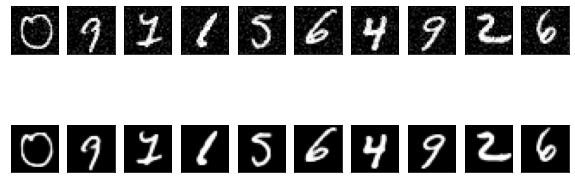

In [ ]:
n = 10
train_output = autoencoder.predict(x_train_noisy)

plt.figure(figsize=(10, 4))
for i in range(n):
    train_size = len(x_train_noisy)
    index = np.random.randint(0, train_size)
    plt.subplot(2, n, i+1)
    plt.imshow(x_train_noisy[index, :, :, 0], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(2, n, n+i+1)
    plt.imshow(train_output[index, :, :, 0], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.show()

In [ ]:
result1 = test_classification(x_train_noisy, y_train, x_test_noisy, y_test)

x_train shape: (60000, 28, 28, 1)
Number of images in x_train 60000
Number of images in x_test 10000
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 28)        280       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 28)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 4732)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               605824    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                1290      
Total params: 607,3

In [ ]:
result2 = test_classification(train_output, y_train, test_output, y_test)

x_train shape: (60000, 28, 28, 1)
Number of images in x_train 60000
Number of images in x_test 10000
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 26, 26, 28)        280       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 28)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 4732)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               605824    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                1290      
Total params: 607,3

In [ ]:
print("Accuracy with noise :",result1[1]*100)
print("Accuracy after denoising :",result2[1]*100)

Accuracy with noise : 97.86999821662903
Accuracy after denoising : 97.71000146865845


In [ ]:
im1 = tf.image.convert_image_dtype(x_train_noisy, tf.float32)
im2 = tf.image.convert_image_dtype(train_output, tf.float32)
psnr = tf.image.psnr(im1, im2, max_val=1.0)
psnr_train = np.mean(psnr)
print(psnr_train)

21.940567
